In [1]:
import torch
import torch.nn as nn 
import torchvision
from torchvision import datasets, transforms, models
from torch.autograd import Variable


from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import io
import requests
import time
import json

In [41]:
device = "cpu" # I'm not sure if it will work out of the box with cuda even if you have a GPU
vgg19 = models.vgg19(pretrained=True)
resnet = models.resnet18(pretrained=True)
vgg19.eval()
resnet.eval()
full_vgg19 = nn.Sequential(model, nn.Softmax(dim=1)).to(device).eval()
full_resnet = nn.Sequential(model, nn.Softmax(dim=1)).to(device).eval()

# Label Conversion

This step is done because the labels for the validation dataset do not match the labels from the pretrained model. 

In [3]:
PATH = 'labels/imagenet_class_index.json'
with open(PATH, 'r') as fp:
    labels_65 = json.load(fp)

# labels_65 is the default labels from pretrained model
labels_65 = {value[0]: int(key) for key,value in labels_65.items()} 

labels_file = open('labels/labels.txt')
labels_490 = {} #labels_490 is the labels from the validation txt
for line in labels_file:
    contents = line.split()
    val = contents[2]
    key = contents[1]
    n_name = contents[0] 
    labels_490.update({int(key): [n_name,val]})

In [4]:
def Convert_labels_file(k_490):
    n_name = labels_490[k_490][0]
    k_65 = labels_65[n_name]
    
    return k_65

In [5]:
ground_truth_handle = open('labels/ILSVRC2012_validation_ground_truth.txt')

count = 0
num_images = 1000
Converted_labels = []
for line in ground_truth_handle:
    if count == num_images:
        break
    k_65 = Convert_labels_file(int(line))
    Converted_labels.append(k_65)
    
    count+=1

In [33]:
def __fgsm(model, x, label, epsilon, targeted, clamp):
    model.zero_grad()

    x = torch.as_tensor(x, device=device)
    x.requires_grad = True
    
    logits = model(x)
    target = torch.LongTensor([label]).to(device)
    loss = nn.CrossEntropyLoss()(logits, target)
    loss.backward()
    
    diff = epsilon * x.grad.sign()
    
    if targeted:
        adv = x - diff
    else:
        adv = x + diff
    
    return adv.clamp(0, 1) if clamp else adv

def fgsm_targeted(model, x, label, epsilon, clamp=True):
    """
    model = neural network with logits output (not softmax)
    x = image 
    label = target label (don't care about the true label)
    epsilon = distance to move 
    clamp = Limit output values to the range [0,1]
    """
    return __fgsm(model, x, label, epsilon, True, clamp)
    
def fgsm_untargeted(model, x, label, epsilon, clamp=True):    
    """
    model = neural network with logits output (not softmax)
    x = image
    label = the true label
    epsilon = distance to move 
    clamp = Limit output values to the range [0,1]
    """
    return __fgsm(model, x, label, epsilon, False, clamp)

def __pgd(model, x, label, k, epsilon, epsilon_step, targeted, clamp):
    x = torch.as_tensor(x, device=device)
    
    x_min = x - epsilon
    x_max = x + epsilon
    
    for i in range(k):
        x = __fgsm(model, x.detach(), label, epsilon_step, targeted, clamp)  
        x = torch.max(x_min, x)
        x = torch.min(x_max, x)
    
    return x

def pgd_targeted(model, x, target, k, epsilon, epsilon_step, clamp=False):
    """
    model = neural network (with logits as output - not probs)
    x = image
    label = target
    k = number of iterations 
    epsilon = maximum allowed distance between input and output in infinity norm
    epsilon_step = distance in infinity norm moved each iteration
    clamp = bool; limit output channels to the interval [0,1]
    """
    return __pgd(model, x, target, k, epsilon, epsilon_step, True, clamp)

def pgd_untargeted(model, x, label, k, epsilon, epsilon_step, clamp=False):
    """
    model = neural network (with logits as output - not probs)
    x = image
    label = true label
    k = number of iterations 
    epsilon = maximum allowed distance between input and output in infinity norm
    epsilon_step = distance in infinity norm moved each iteration
    clamp = bool; limit output channels to the interval [0,1]
    """
    return __pgd(model, x, label, k, epsilon, epsilon_step, False, clamp)

def plotter(image, adverserial, full_model):
    """Show the original (img), adversarial attack (adv), and some more stuff. Pass images as pytorch tensors"""
    image = image.cpu().detach()
    adverserial = adverserial.cpu().detach()
    
    probability_original = full_model(image.to(device)).cpu().detach().numpy()
    origial_image = image.numpy()[0]
    
    probability_adverserial = full_model(adverserial.to(device)).cpu().detach().numpy()
    adverserial_image = adverserial.numpy()[0]
    
    f, axes = plt.subplots(1,3, figsize=(15, 6))
    
    ax = axes[0]
    prediction = probability_original.argmax()
    ax.set_title("Original, class: {} ({:.0f} %): '{}'".format(
        prediction, 100*probability_original[0, prediction], labels[prediction])
    )
    ax.imshow(np.transpose(origial_image, (1,2,0)))
    
    ax = axes[1]
    prediction = probability_adverserial.argmax()
    ax.set_title("Adverserial, class: {} ({:.0f} %): '{}'".format(
        prediction, 100*probability_adverserial[0, prediction], labels[prediction])
    )
    ax.imshow(np.transpose(adverserial_image, (1,2,0)))
    
    ax = axes[2]
    diff = np.transpose(adverserial_image - origial_image, (1,2,0))
    plt.imshow(diff + 0.5)
    plt.show()

## Attack 100 validation images

Note: This will take some time.

In [ ]:
min_img_size = 224 
fro = 150
imgs =  100 # Choose number of images you want to check

epsilons = [0.01, 0.05, 0.10, 0.20, 0.30]
epsilon_step = 0.025
k = 5

adv_accuracies = []

# Choose model
model = vgg19

for epsilon in epsilons:
    
    original_correct = 0
    adv_correct = 0
    cls = {}
    
    for i in range(fro,fro+imgs):
        if(i<10):
            directory_imgs = 'ILSVRC2012_img_val/ILSVRC2012_val_00000' +'00' +str(i) 
        elif(i<100):
            directory_imgs = 'ILSVRC2012_img_val/ILSVRC2012_val_00000' +'0' +str(i)
        elif(i<1000):
            directory_imgs = 'ILSVRC2012_img_val/ILSVRC2012_val_00000' + str(i)
        filename = directory_imgs 
        img = Image.open(directory_imgs+'.JPEG')

        # Transformation of image
        pre_transform = transforms.Compose([transforms.Resize((min_img_size,min_img_size)), transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) ])
        image_tensor = pre_transform(img)
        image_tensor = image_tensor.unsqueeze(0) # add batch dimension.  C X H X W ==> B X C X H X W
        img_variable = Variable(image_tensor, requires_grad=True) #convert tensor into a variable

        # Classification
        output = model.forward(img_variable)
        original_class = torch.max(output.data, 1)[1][0]  #get an index(class number) of a largest element
        original_class = original_class.item()
        cls.update({i:original_class})

        # Adversarial attack
        #adv = fgsm_untargeted(model, image_tensor, label=original_class, epsilon = epsilon, clamp=True)
        adv = pgd_untargeted(model, image_tensor, original_class, k, epsilon, epsilon_step, clamp=False)
        adv = adv.cpu().detach()
        probability_adverserial = full_vgg19(adv.to(device)).cpu().detach().numpy()
        adverserial_image = adv.numpy()[0]
        prediction = probability_adverserial.argmax()

        # Computing Accuracies
        if(original_class == Converted_labels[i-1]):
            original_correct+=1
        if(prediction == Converted_labels[i-1]):
            adv_correct+=1

        print(i,Converted_labels[i-1],original_class, prediction)


    original_correct = original_correct/imgs*100 
    adv_correct = adv_correct/imgs*100
    print('Original_Accuracy: '+ str(original_correct) + ' %' )
    print('Adversarial_Accuracy: '+ str(adv_correct) + str(' %'))
    
    adv_accuracies.append(adv_correct)

epsilons.insert(0,0)
adv_accuracies.insert(0,original_correct)
    
    

150 975 977 978
151 620 922 681
152 637 637 637
153 39 39 39
154 115 115 110
155 937 937 936
156 272 274 274
157 277 277 277
158 763 763 763
159 789 905 736
160 646 646 646
161 213 214 234
162 493 894 789
163 647 647 647
164 504 504 504
165 937 937 937
166 687 687 687
167 781 781 781
168 666 666 666
169 583 583 583
170 158 158 158
171 825 825 825
172 212 212 212
173 659 659 659
174 257 257 257
175 436 436 717
176 196 199 199
177 140 140 140
178 248 250 248
179 339 339 339
180 230 230 230
181 361 731 361
182 544 926 567
183 935 935 961
184 638 445 639
185 627 656 627
186 289 289 285
187 867 867 867
188 272 272 274
189 103 979 885
190 584 823 584
191 180 179 243
192 703 448 644
193 449 449 975
194 771 771 771
195 118 118 118
196 396 396 396
197 934 922 438
198 16 16 16
199 548 548 548
200 993 993 993
201 704 704 704
202 457 823 457
203 233 233 233
204 401 543 747
205 827 482 481
206 376 376 382
207 146 85 362
208 606 606 811
209 922 922 916
210 516 431 431
211 284 284 284
212 889 889 889

# Cross-model attack
Train adversarial attack on Resnet, attack VGG19

In [44]:
min_img_size = 224 
fro = 150
imgs =  100 # Choose number of images you want to check
epsilons = [0.01, 0.05, 0.10, 0.20, 0.30]
adv_accuracies = []

defender = resnet
defender_full = full_resnet

attacker = vgg19
attacker_full = full_vgg19

for epsilon in epsilons:
    
    original_correct = 0
    adv_correct = 0
    cls = {}
    
    for i in range(fro,fro+imgs):
        if(i<10):
            directory_imgs = 'ILSVRC2012_img_val/ILSVRC2012_val_00000' +'00' +str(i) 
        elif(i<100):
            directory_imgs = 'ILSVRC2012_img_val/ILSVRC2012_val_00000' +'0' +str(i)
        elif(i<1000):
            directory_imgs = 'ILSVRC2012_img_val/ILSVRC2012_val_00000' + str(i)
        filename = directory_imgs 
        img = Image.open(directory_imgs+'.JPEG')

        # Transformation of image
        pre_transform = transforms.Compose([transforms.Resize((min_img_size,min_img_size)), transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) ])
        image_tensor = pre_transform(img)
        image_tensor = image_tensor.unsqueeze(0) # add batch dimension.  C X H X W ==> B X C X H X W
        img_variable = Variable(image_tensor, requires_grad=True) #convert tensor into a variable

        # Classification
        output = defender.forward(img_variable)
        original_class = torch.max(output.data, 1)[1][0]  #get an index(class number) of a largest element
        original_class = original_class.item()
        cls.update({i:original_class})

        # Adversarial attack
        adv = fgsm_untargeted(attacker, image_tensor, label=original_class, epsilon = epsilon, clamp=True)
        #adv = pgd_untargeted(model, image_tensor, original_class, k=10, epsilon, epsilon_step, clamp=False)
        adv = adv.cpu().detach()
        probability_adverserial = defender_full(adv.to(device)).cpu().detach().numpy()
        adverserial_image = adv.numpy()[0]
        prediction = probability_adverserial.argmax()

        # Computing Accuracies
        if(original_class == Converted_labels[i-1]):
            original_correct+=1
        if(prediction == Converted_labels[i-1]):
            adv_correct+=1

        print(i,Converted_labels[i-1],original_class, prediction)


    original_correct = original_correct/imgs*100 
    adv_correct = adv_correct/imgs*100
    print('Original_Accuracy: '+ str(original_correct) + ' %' )
    print('Adversarial_Accuracy: '+ str(adv_correct) + str(' %'))
    
    adv_accuracies.append(adv_correct)

epsilons.insert(0,0)
adv_accuracies.insert(0,original_correct)
    
    

150 975 978 977
151 620 681 549
152 637 637 620
153 39 39 42
154 115 115 110
155 937 937 111
156 272 274 209
157 277 277 277
158 763 763 763
159 789 579 720
160 646 646 646
161 213 234 163
162 493 894 708
163 647 647 551
164 504 504 504
165 937 937 973
166 687 687 699
167 781 781 921
168 666 666 419
169 583 583 583
170 158 158 238
171 825 825 700
172 212 212 212
173 659 659 659
174 257 257 257
175 436 436 468
176 196 199 199
177 140 140 142
178 248 248 248
179 339 339 794
180 230 231 255
181 361 361 862
182 544 909 659
183 935 935 961
184 638 445 921
185 627 656 831
186 289 289 794
187 867 867 908
188 272 272 549
189 103 103 632
190 584 710 813
191 180 180 243
192 703 703 693
193 449 449 978
194 771 771 844
195 118 118 78
196 396 396 78
197 934 711 419
198 16 16 128
199 548 548 405
200 993 993 78
201 704 704 794
202 457 457 723
203 233 233 295
204 401 543 419
205 827 528 605
206 376 376 111
207 146 82 913
208 606 606 419
209 922 922 921
210 516 431 516
211 284 284 264
212 889 889 432
2

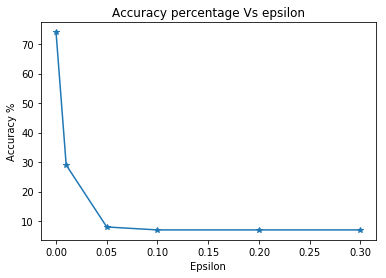

In [48]:
plt.plot(epsilons, adv_accuracies, '*-')
plt.title("Accuracy percentage Vs epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy %")
plt.show()